# American and Bermudan Option pricer

In [1]:
# Packages used
import numpy as np
import matplotlib.pyplot as plt
from scipy import odr
from helper import *
import keras
from scipy.stats import norm
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [2]:
def GBM_exact(T, S, sigma, r, M):
    S_all = []
    S_all.append(S)
    dt = T/M
    Zm = np.random.normal(size=M)
    for i in range(M-1):
        S_all.append(S_all[i] * np.exp((r-0.5*sigma**2) * dt + sigma * np.sqrt(dt) * Zm[i])) 
    return S_all

## Simulations Run with Data from paper

American option should be priced at .1144

In [3]:
# Parameters
K=1.1; M=4; r=.06; realizations=8; T=M

# Matrix
path_matrix = np.array([
[1.00, 1.09, 1.08, 1.34],
[1.00, 1.16, 1.26, 1.54],
[1.00, 1.22, 1.07, 1.03],
[1.00, 0.93, 0.97, 0.92],
[1.00, 1.11, 1.56, 1.52],
[1.00, .76, 0.77, 0.90],
[1.00, 0.92, 0.84, 1.01],
[1.00, 0.88, 1.22, 1.34]])

In [4]:
# Generate cash flows under Longstaff-Schwarz
[cash_flows, somehting_else]= value_option_schwarz(T,M,K,path_matrix, r, realizations, option="put")

# Discount cash flows
for time in range(cash_flows.shape[1]):
    cash_flows[:,time]*=np.exp(-r*time)
print(f'Price of American Option is: {np.sum(cash_flows[0:])/realizations}')

Price of American Option is: 0.11443433004505696


In [5]:
cash_flows_test = value_option_schwarz_test(M,K,path_matrix, r, realizations, option="put")

# Discount cash flows
for time in range(cash_flows.shape[1]):
    cash_flows_test[:,time]*=np.exp(-r*time)
print(f'Price of American Option is: {np.sum(cash_flows_test[0:])/realizations}')    

Price of American Option is: 0.11443433004505696


In [6]:
# Unit test Bermudian pricer by giving it same amount of exericse options as American
exercise_dates = [1,2,3,4]
cash_flow_bermudan = value_option_bermudan(M, K, path_matrix, r, realizations, exercise_dates, option="put")

for time in range(cash_flow_bermudan.shape[1]):
    cash_flow_bermudan[:,time] *= np.exp(-r*time)
print(f'Price of Bermudan Option is: {np.sum(cash_flow_bermudan[0:])/realizations}')    

Price of Bermudan Option is: 0.11561153571203728


In [7]:
# Fewer exercise points should lead to lower option price
exercise_dates = [2,3,4]
cash_flow_bermudan = value_option_bermudan(M, K, path_matrix, r, realizations, exercise_dates, option="put")

for time in range(cash_flow_bermudan.shape[1]):
    cash_flow_bermudan[:,time] *= np.exp(-r*time)
print(f'Price of Bermudan Option is: {np.sum(cash_flow_bermudan[0:])/realizations}')    

Price of Bermudan Option is: 0.056380739270260896


In [8]:
# Unit test Bermudian pricer by giving it same amount of exericse options as American
exercise_dates = [1,2,3,4]
cash_flow_bermudan = value_option_bermudan(M, K, path_matrix, r, realizations, exercise_dates, option="put")

for time in range(cash_flow_bermudan.shape[1]):
    cash_flow_bermudan[:,time] *= np.exp(-r*time)
print(f'Price of Bermudan Option is: {np.sum(cash_flow_bermudan[0:])/realizations}')  

Price of Bermudan Option is: 0.11561153571203728


## Simulation based on GBM

In [9]:
# Variables used
T = M = N = 4
K = 1.1
S = 1
sigma = 0.2
r = 0.06
realizations = 2000


In [10]:
repititions = 30
europeans = np.zeros(repititions)
americans = np.zeros(repititions)
dt = T/M


for i in range(repititions):
    s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(realizations)])
    europeans[i] = np.sum(np.maximum(0,K-s_all[:,-1]))/realizations * np.exp(-r * T)
    [option_cash_flow, cash_flows] = value_option_schwarz(T,M,K,s_all, r, realizations,order=2,option="put")
    
    for time in range(option_cash_flow.shape[1]):
        option_cash_flow[:,time]*=np.exp(-r*(time*dt))
    americans[i] =  np.sum(option_cash_flow)/realizations

<AxesSubplot:>

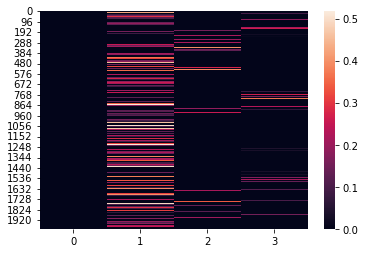

In [11]:
sns.heatmap(cash_flows)

In [12]:
BSM_put(1, K, r, sigma, T)

0.0899083987054129

In [13]:
np.mean(europeans)

0.09067992733968468

In [14]:
np.std(americans)/np.sqrt(repititions)

0.00045281272695975875

In [15]:
payoffs = np.maximum(K-s_all[:,:],0)
dt = T/M

for time in range(payoffs.shape[1]):
    payoffs[:,time]*=np.exp(-r*(dt*time))
    
max_payoffs = []
for path in range(payoffs.shape[0]):
    max_payoffs.append(max(payoffs[path]))
    
np.mean(max_payoffs)

0.19166117386336362

In [16]:
np.mean(americans)

0.12093363703472379

In [17]:
np.std(americans)

0.0024801574488128755

### Neural Net

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Input
import keras.optimizers as opt
from keras.constraints import Constraint
from keras import backend as keras_backend
import tensorflow as tf

In [42]:
class neural_bermudan_fitter:
    def __init__(self, r, sigma, stock_paths, K, dates, option="put", ittol=10, T=1, nodes=10, epochs=10, pre_trained_model=None):
        self.stock_paths = stock_paths
        self.K = K
        assert all(earlier > later for earlier, later in zip(dates, dates[1:])), 'the dates should be in descending order'
        self.dates = dates
        
        self.T=T
        self.r = r
        self.sigma = sigma
        self.option = option.lower()
        self.N = len(self.stock_paths)
        self.M = len(self.dates)
        self.num_stoch_movements = len(self.stock_paths[0])
        self.nodes = nodes
        self.epochs = epochs
        self.ittol=ittol
        
        self.evaluate_final()
        
        #step 3 of Jain
        self.beta = np.random.uniform(size=(self.N,1))
        self.nnets = []
        if pre_trained_model:
            self.nnets.append(pre_trained_model)
        else:
            self.setup_network()
        self.V = np.zeros(self.N)
        self.Q_hat = np.zeros(self.N)
        self.callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
        self.histories = []
        self.opt_val = np.zeros((self.nodes, len(self.dates), self.N))
        
    def evaluate_final(self):
        # step 2 of algorithm in Jain paper
        if self.option == 'call':
            self.h = tf.maximum(self.stock_paths[:,-1] - self.K,0)
        else:
            self.h = tf.maximum(self.K - self.stock_paths[:,-1],0)
            
    def setup_network(self):
        nn = Sequential([
                    Input(shape=(1)),
                    Dense(self.nodes,activation='relu',trainable=True, kernel_initializer = 'random_uniform'),
                    Dense(1,activation='linear',trainable=True, kernel_initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None))
                    ])
        nn.compile(tf.optimizers.Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
        
        if self.option=="call":
            Y_train = np.maximum(s_all[:,-1] - K, 0)
        else:
            Y_train = np.maximum(K - s_all[:,-1], 0)

        X_train = s_all[:,-1]
        
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
        history = nn.fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=500, verbose=0, callbacks=[callback])
        if history.history['loss'][-1] > 1:
            print("warning. NN didn't converge")
        
        self.nnets.append(nn)
    
    def copy_network(self):
        new_model = keras.models.clone_model(self.nnets[-1])
        new_model.compile(tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
        new_model.set_weights(self.nnets[-1].get_weights())
        self.nnets.append(new_model)
        
    def run_pricing_simulation(self):        
        for m,date in enumerate(self.dates[0:len(self.dates)-1]):
            #step 5
            self.fit_model(m,date)
            w_vect = np.array(self.nnets[-1].layers[0].get_weights()[0]).reshape(-1)
            w_vect_2 = np.array(self.nnets[-1].layers[1].get_weights()[0]).reshape(-1)
            strikes = np.array(self.nnets[-1].layers[0].get_weights()[1]).reshape(-1)
            bias_2 = np.array(self.nnets[-1].layers[1].get_weights()[1]).reshape(-1)
            
            # steps 6 to 12
            #time_to_maturity =  (self.dates[m] - self.dates[m+1]) / self.dates[0]
            time_to_maturity = 1
            for node in range(self.nodes):
                # maybe change m-1 to m for all options
                if w_vect[node] > 0 and strikes[node] > 0:
                    # Forward contract
                    #self.opt_val[node, m, :] = (w_vect[node]*self.stock_paths[:,self.dates[m]]+strikes[node]) * np.exp(-r*(self.dates[m] - self.dates[m+1]))
                    pass
                elif w_vect[node] < 0 and strikes[node] > 0:
                    # Put Option
                    k = -strikes[node]/w_vect[node]
                    put_pricing = lambda s: BSM_put(s, k, self.r, self.sigma, time_to_maturity)
                    find_put_price = np.vectorize(put_pricing)
                    self.opt_val[node, m, :] =  find_put_price(self.stock_paths[:,self.dates[m]]) * w_vect_2[node] + bias_2
                elif w_vect[node] > 0 and strikes[node] < 0:
                    # Call option
                    k = -strikes[node]/w_vect[node]
                    call_pricing = lambda s: BSM_call(s, k, self.r, self.sigma, time_to_maturity)
                    find_call_price = np.vectorize(call_pricing)
                    self.opt_val[node, m, :] =  find_call_price(self.stock_paths[:,self.dates[m]]) * w_vect_2[node] + bias_2
            
            for s in range(len(self.stock_paths[:,self.dates[m+1]])): 
                self.Q_hat[s] = np.sum(self.opt_val[:,m,s])
                           
            self.copy_network()

            
    def fit_model(self,m, date):
        if self.option=='call':
            self.h = np.maximum(0, self.stock_paths[:,date] - self.K)
            for i, value in enumerate(h):
                if value > self.Q_hat[i]:
                    Y_train[i] = value
                else:
                    Y_train[i] = self.Q_hat[i]
            #print(Y_train)
        else:
            self.h = np.maximum(0, self.K - self.stock_paths[:,date])
            try:
                for i, value in enumerate(self.h):
                    if value > self.Q_hat[i]:
                        Y_train[i] = value
                    else:
                        Y_train[i] = self.Q_hat[i]
            except:
                print(self.h)
            #print(Y_train)
            
            
        X_train = np.array(self.stock_paths[:,date])
        self.histories.append(self.nnets[-1].fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=self.epochs, callbacks=[self.callback], verbose=0))
        i=0
        while self.histories[-1].history['loss'][-1] > 100 and i< self.ittol:
            i+=1
            print("warning. NN didn't converge")
            print(f"loss: {self.histories[-1].history['loss'][-1]}, time: {date}")
            self.histories.append(self.nnets[-1].fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=self.epochs, callbacks=[self.callback], verbose=0))


In [ ]:
# Pre train a NN at the standard payoffs

In [20]:
nodes = 20

In [21]:
nn = Sequential([
            Input(shape=(1)),
            Dense(nodes,activation='relu',trainable=True, kernel_initializer = 'random_uniform'),
            Dense(1,activation='linear',trainable=True, kernel_initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None))
            ])
nn.compile(tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [22]:
Y_train = np.maximum(K - s_all[:,-1], 0)

X_train = s_all[:,-1]

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
history = nn.fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=500, verbose=0, callbacks=[callback])
if history.history['loss'][-1] > 1:
    print("warning. NN didn't converge")

In [64]:
dates = [0,1,2,3]
dates.reverse()

In [65]:
nf = neural_bermudan_fitter(r, sigma, s_all,  K, dates, epochs = 1000, pre_trained_model= nn, nodes=nodes)

In [66]:
nf.run_pricing_simulation()

In [67]:
# Final portfolio
w_vect = np.array(nf.nnets[-1].layers[0].get_weights()[0]).reshape(-1)
strikes = np.array(nf.nnets[-1].layers[0].get_weights()[1]).reshape(-1)
w_vect_2 = np.array(nf.nnets[-1].layers[1].get_weights()[0]).reshape(-1)
strikes_2 = np.array(nf.nnets[-1].layers[1].get_weights()[1]).reshape(-1)

positions = identify_positions(w_vect, strikes)[4]

Ks=-strikes/w_vect

In [68]:
positions

array(['N', 'P', 'N', 'N', 'P', 'N', 'N', 'P', 'P', 'N', 'N', 'P', 'N',
       'P', 'N', 'N', 'N', 'N', 'N', 'P'], dtype='<U1')

In [69]:
strikes_2

array([0.08304176], dtype=float32)

In [70]:
strikes

array([-0.01192533,  0.5299166 ,  0.        ,  0.        ,  0.5228319 ,
        0.        ,  0.        ,  0.55386156,  0.53159046,  0.        ,
        0.        ,  0.5598914 ,  0.        ,  0.5775137 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.52602756],
      dtype=float32)

In [71]:
# final Bermudan Put value
total = 0
for i, position in enumerate(positions):
    if position == 'P':
        total+=BSM_put(1, Ks[i], r, sigma, 1)*w_vect_2[i] + strikes_2
        
total/len(positions[positions=='P'])

array([0.34538183], dtype=float32)

In [72]:
# upper bound
np.mean(max_payoffs)

0.19166117386336362

In [73]:
# lower bound
np.mean(americans)

0.12093363703472379

In [74]:
# european
BSM_put(1,K, r,sigma,0.25)

0.09605892634054225

In [40]:
totals = []
dates = [0,1,2,3]
dates.reverse()

for i in tqdm(range(2)):
    s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(realizations)])
    
    nn = Sequential([
            Input(shape=(1)),
            Dense(nodes,activation='relu',trainable=True, kernel_initializer = 'random_uniform'),
            Dense(1,activation='linear',trainable=True, kernel_initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None))
            ])
    nn.compile(tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    
    Y_train = np.maximum(K - s_all[:,-1], 0)
    X_train = s_all[:,-1]
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
    history = nn.fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=500, verbose=0, callbacks=[callback])
    if history.history['loss'][-1] > 1:
        print("warning. NN didn't converge")
        
        
    nf = neural_bermudan_fitter(r, sigma, s_all,  K, dates, epochs = 1000, pre_trained_model= nn, nodes=nodes)
    nf.run_pricing_simulation()
    
    # Final portfolio
    w_vect = np.array(nf.nnets[-1].layers[0].get_weights()[0]).reshape(-1)
    strikes = np.array(nf.nnets[-1].layers[0].get_weights()[1]).reshape(-1)
    w_vect_2 = np.array(nf.nnets[-1].layers[1].get_weights()[0]).reshape(-1)
    strikes_2 = np.array(nf.nnets[-1].layers[1].get_weights()[1]).reshape(-1)

    positions = identify_positions(w_vect, strikes)[4]

    Ks=-strikes/w_vect
    
    total = 0
    for i, position in enumerate(positions):
        if position == 'P':
            total+=BSM_put(1, Ks[i], r, sigma, 1)*(w_vect_2[i]) + strikes_2

    totals.append(total/len(positions[positions=='P']))

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.54s/it]


In [41]:
totals

[array([0.288626], dtype=float32), array([0.28605324], dtype=float32)]

In [37]:
# Figures for presentation

In [38]:
# Pre trained NN

In [727]:
Y_train = np.maximum(K - s_all[:,-1], 0)

X_train = s_all[:,-1]

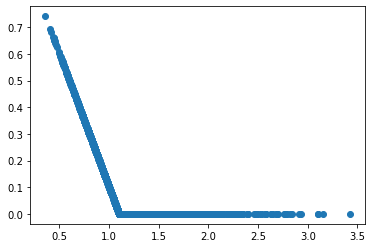

In [728]:
plt.scatter(X_train, Y_train)

In [729]:
S = np.linspace(0.1,2,20)
V = np.zeros(S.shape)

V = nn.predict(np.array(S).reshape(-1,1))

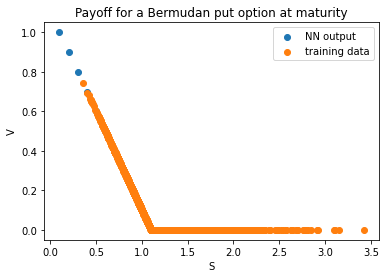

In [730]:
plt.scatter(S,V, label="NN output")
plt.scatter(X_train, Y_train, label="training data")
plt.legend()
plt.xlabel("S")
plt.ylabel("V")
plt.title("Payoff for a Bermudan put option at maturity")
plt.savefig("figures/put_at_maturity_NN.jpg", dpi=300)

In [43]:
# NN payoff at later times

In [731]:
Y_train = np.maximum(K - s_all[:,-1], 0)

X_train = s_all[:,-1]

In [732]:
m=2
V = np.zeros(len(nf.stock_paths[:,nf.dates[m]]))

for s in range(len(nf.stock_paths[:,nf.dates[m]])): 
    V[s] = np.sum(nf.opt_val[:,m,s])

h = np.maximum(0, nf.K - nf.stock_paths[:,dates[m]])

for i, value in enumerate(h):
    if value > V[i]:
        Y_train[i] = value
    else:
        Y_train[i] = V[i]
#Y_train = np.maximum(nf.h, V)

X_train = np.array(nf.stock_paths[:,dates[m]]).reshape(1,-1)

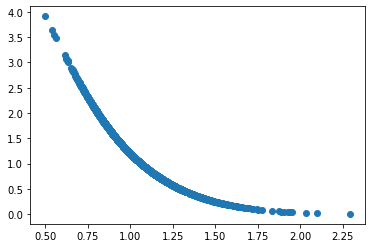

In [733]:
plt.scatter(X_train, Y_train)

In [734]:
V = nf.nnets[m].predict(np.array(S).reshape(-1,1))

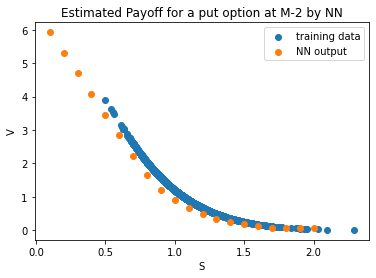

In [735]:
plt.scatter(X_train, Y_train, label="training data")
plt.scatter(S,V, label="NN output")
#plt.scatter(X_train, Y_train, label="training data")
plt.legend()
plt.xlabel("S")
plt.ylabel("V")
plt.title(f"Estimated Payoff for a put option at M-{m} by NN")
plt.savefig(f"figures/M-{m}_payoff_NN.jpg", dpi=300)